## NVIDIA 加速推理平台介绍 ：https://build.nvidia.com/
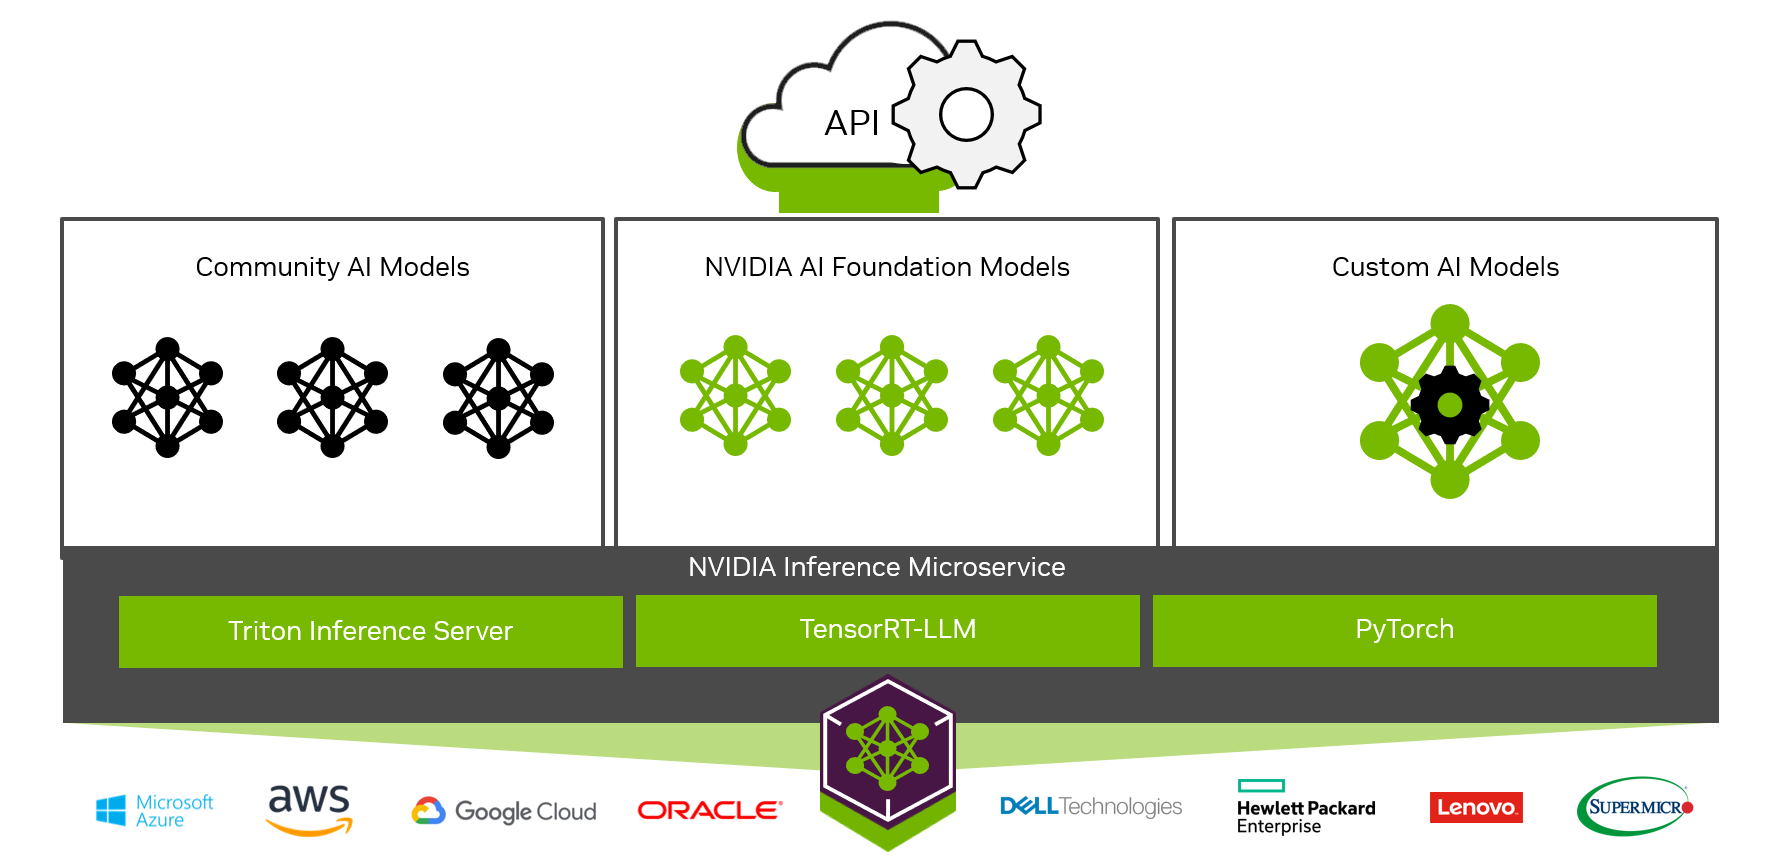

In [1]:
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = "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"
)

completion = client.chat.completions.create(
  model="meta/llama-3.1-405b-instruct",
  messages=[{"role":"user","content":"泰坦尼克号的导演是谁"}],
  temperature=0.2,
  top_p=0.7,
  max_tokens=1024,
  stream=True
)

for chunk in completion:
  if chunk.choices[0].delta.content is not None:
    print(chunk.choices[0].delta.content, end="")


詹姆斯·卡梅隆

---
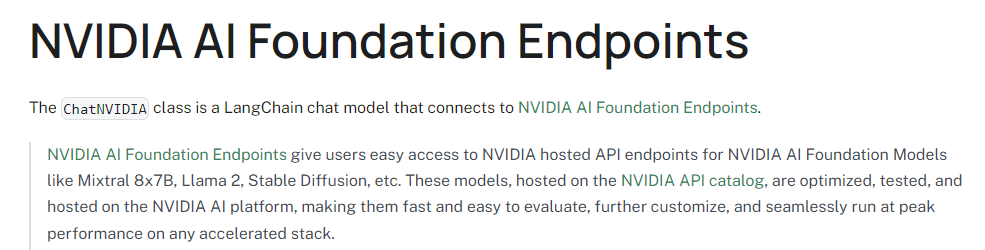
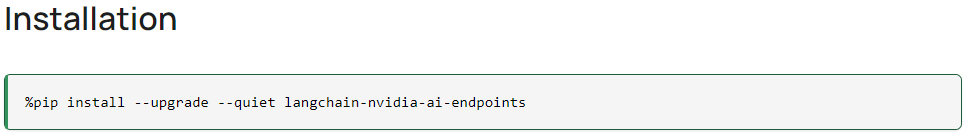
https://python.langchain.com/v0.1/docs/integrations/chat/nvidia_ai_endpoints/#rag-context-models

In [2]:
#!pip install faiss-cpu # replace with faiss-gpu if you are using GPU

### Step 1  - 使用NVIDIA_API_KEY

In [3]:
import getpass
import os

if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

In [4]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
ChatNVIDIA.get_available_models()

[Model(id='google/recurrentgemma-2b', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-recurrentgemma-2b'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='google/codegemma-1.1-7b', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-codegemma-1.1-7b'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='microsoft/phi-3-small-128k-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-phi-3-small-128k-instruct'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/neva-22b', model_type='vlm', client='ChatNVIDIA', endpoint='https://ai.api.nvidia.com/v1/vlm/nvidia/neva-22b', aliases=['ai-neva-22b', 'playground_neva_22b', 'neva_22b'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='google/gemma-7b', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-gemma-7b', 'playgrou

### Step 2 - 初始化SLM
**这里我们使用 phi-3-small-128k-instruct** 

In [5]:
llm = ChatNVIDIA(model="microsoft/phi-3-small-128k-instruct", nvidia_api_key=nvapi_key, max_tokens=512)
result = llm.invoke("明日剧场是什么？")
print(result.content)

 为了回答这个问题，您需要查看当地剧场的日程安排。这通常可以通过剧场的官方网站、社交媒体账号或者通过电子剧票预订系统来完成。一旦您获得了明天的剧目列表，您就可以根据您的兴趣和可用时间选择一个剧目。


## RAG的工作流程
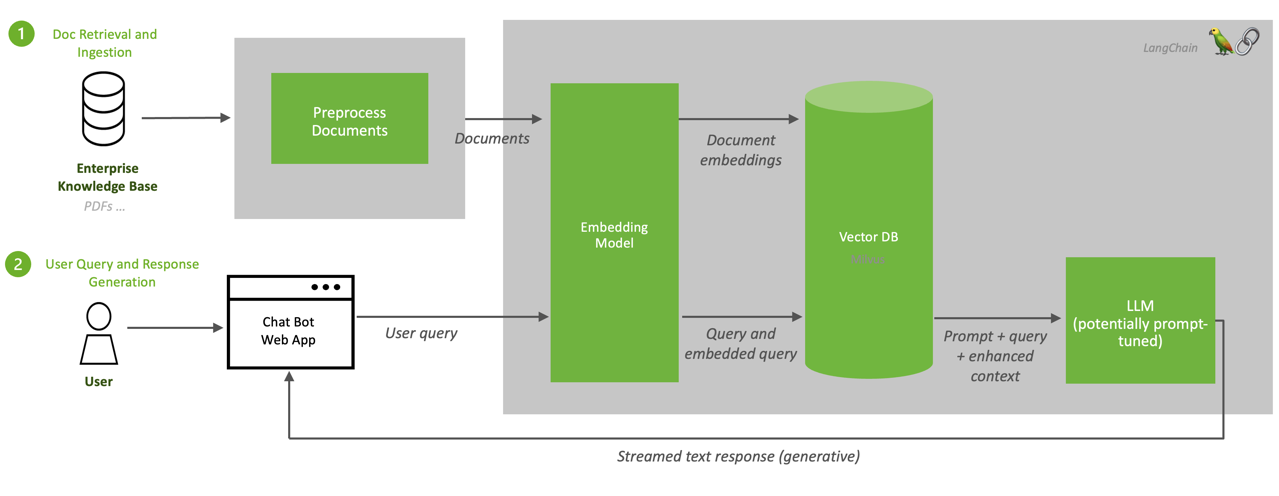

### Step 3 - 初始化ai-embed-qa-4向量模型

In [6]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="NV-Embed-QA")

### Step 4 - 获取文本数据集

In [7]:
import os
from tqdm import tqdm
from pathlib import Path

# Here we read in the text data and prepare them into vectorstore
ps = os.listdir("./zh_data/")
data = []
sources = []
for p in ps:
    if p.endswith('.txt'):
        path2file="./zh_data/"+p
        with open(path2file,encoding="utf-8") as f:
            lines=f.readlines()
            for line in lines:
                if len(line)>=1:
                    data.append(line)
                    sources.append(path2file)

### Step 5 - 进行一些基本的清理并删除空行

In [8]:
documents=[d for d in data if d != '\n']
len(data), len(documents), data[0]

(1,
 1,
 '“明日剧场”数智虚拟展演平台将现代科技与剧场、身体、造型、空间、影像等元素相结合，以AI人工智能和区块链技术为载体，分为数字人、文化艺术、交互、网络、图形学、人工智能等六大模块，是展演领域首个基于视频通信和运动捕捉技术将元宇宙虚拟世界概念可视化、智能化的平台。')

### Step 6a - 将文档处理到 faiss vectorstore 并将其保存到磁盘

In [9]:
# Here we create a vector store from the documents and save it to disk.
from operator import itemgetter
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import CharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import faiss

In [28]:
  # 只需要执行一次，后面可以重读已经保存的向量存储
  text_splitter = CharacterTextSplitter(chunk_size=400, separator=" ")
  docs = []
  metadatas = []

  for i, d in enumerate(documents):
      splits = text_splitter.split_text(d)
       #print(len(splits))
      docs.extend(splits)
      metadatas.extend([{"source": sources[i]}] * len(splits))

  store = FAISS.from_texts(docs, embedder , metadatas=metadatas)
  store.save_local('./zh_data/nv_embedding')

### Step 6b - 重读之前处理并保存的 Faiss Vectore 存储

In [29]:
# Load the vectorestore back.
store = FAISS.load_local("./zh_data/nv_embedding", embedder,allow_dangerous_deserialization=True)

### Step 7- 提出问题并基于phi-3-small-128k-instruct模型进行RAG检索

In [30]:
retriever = store.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("明日剧场是什么？")

' 明日剧场是一项名为“明日剧场”的数智虚拟展演平台。它将现代科技与剧场、身体、造型、空间、影像等元素相结合。该平台分为六大模块：数字人、文化艺术、交互、网络、图形学、人工智能。它是展演领域首个基于视频通信和运动捕捉技术将元宇宙虚拟世界概念可视化、智能化的平台。'

* NVIDIA AI Endpoint介绍页面： https://python.langchain.com/v0.1/docs/integrations/chat/nvidia_ai_endpoints/
* NVIDIA NIM页面： https://build.nvidia.com/explore/discover
* NVIDIA DLI课程学习资料页面：https://www.nvidia.cn/training/online/
------------------

![](https://v.png.pub/imgs/2024/06/24/d64b7856c05fa5d4.png)
